# Tutorial: Running Abstraction Code

This notebook is a brief tutorial providing a summary illustration of how to use the code in *src/SCMMappings.py* to instantiate and work with abstractions.

In [1]:
import os
os.chdir(os.path.abspath(os.path.pardir))

In [2]:
import numpy as np

## Overview

The code we provide is supposed to help the user work with $(R,a,\alpha)$ abstractions [Rischel2020], and allow for a simple computation of relevant quantities.

The overall ideal workflow is as follows:
1. Definition of SCMs using the $\mathtt{CBN}$ class, a wrapper for the *$\mathtt{BN}$* class from the *[pgmpy](https://pgmpy.org/index.html)* library.
2. Definition of an abstraction between two models using a $\mathtt{Abstraction}$ object from *src/SCMMappings.py*.
3. (Optional) Use of the $\mathtt{Abstraction}$ object to perform basic computations on the abstraction.
4. (Optional) Instantiation of a $\mathtt{AbstractionPrinter}$ object to print out and plot the abstraction.
5. (Optional) Instantiation of a $\mathtt{ICEvaluator}$ object to compute abstraction error.

## Defintion of SCMs

Finite SCMs with finite domain are implemented using the $\mathtt{CBN}$ class, a simple wrapper the offer additional custom functions to the class $\mathtt{BN}$ in the *pgmpy* library. Transition function/mechanisms/structural funcitons are implemented as stochastic matrices.

In [3]:
from src.CBN import CausalBayesianNetwork as CBN
from pgmpy.factors.discrete import TabularCPD as cpd

The following code implements and verifies the lung cancer toy model $\mathcal{M}$ (see first notebook for a complete description of the model) [Rischel2020].

In [4]:
M0 = CBN([('Smoking','Tar'),('Tar','Cancer')])

cpdS = cpd(variable='Smoking',
          variable_card=2,
          values=[[.8],[.2]],
          evidence=None,
          evidence_card=None)
cpdT = cpd(variable='Tar',
          variable_card=2,
          values=[[1,.2],[0.,.8]],
          evidence=['Smoking'],
          evidence_card=[2])
cpdC = cpd(variable='Cancer',
          variable_card=2,
          values=[[.9,.6],[.1,.4]],
          evidence=['Tar'],
          evidence_card=[2])

M0.add_cpds(cpdS,cpdT,cpdC)
M0.check_model()

True

Similarly, we implement a simpler lung cancer toy model $\mathcal{M'}$ (see first notebook for a complete description of the model) [Rischel2020].

In [5]:
M1 = CBN([('Smoking_','Cancer_')])

cpdS = cpd(variable='Smoking_',
          variable_card=2,
          values=[[.8],[.2]],
          evidence=None,
          evidence_card=None)
cpdC = cpd(variable='Cancer_',
          variable_card=2,
          values=[[.9,.66],[.1,.34]],
          evidence=['Smoking_'],
          evidence_card=[2])

M1.add_cpds(cpdS,cpdC)
M1.check_model()

True

## Definition of an abstraction

An abstraction can be defined using the $\mathtt{Abstraction}$ object from *src/SCMMappings.py*.

In [6]:
from src.SCMMappings import Abstraction

An abstraction is made up of three elements:
- A set of relevant variable $R$ implemented as a list of nodes in $\mathcal{M}$;
- A surjective map from $R$ to the nodes in $\mathcal{M'}$ implemented as a dictionary indexed by $R$;
- A collection of maps $\alpha_{X'}$ from the outcomes in $\mathcal{M}$ to the outcomes in $\mathcal{M'}$ implemented as a dictionary of binary matrices indexed by the variables in $\mathcal{M'}$.

A more detailed explanation of each element is available in the first notebook.

In [7]:
R = ['Smoking','Cancer']

a = {'Smoking': 'Smoking_',
    'Cancer': 'Cancer_'}

alphas = {'Smoking_': np.eye(2),
         'Cancer_': np.eye(2)}

We can now instatiate an $\mathtt{Abstraction}$ object.

In [8]:
A = Abstraction(M0,M1,R,a,alphas)

Initialization of this object verifies that the elements $R,a,\alpha$ are defined on existing variables, and that surjectivity is respected.

## Using an abstraction

The $\mathtt{Abstraction}$ object provides a few basic functions to work with the abstraction.

First, we can access the property fields of the abstraction object or query advanced properties. For instance, we can query the cardinality of domain and codomain of a specific $\alpha_{X'}$ map.

In [9]:
A.get_cardinalities_alpha('Smoking_')

(2, 2)

Second, elementary property of the abstraction may be verified. For instance, we can check whether there is an isomorphism between $R$ and the nodes in $\mathcal{M'}$. Some of these properties are discussed in the second notebook.

In [10]:
A.is_varlevel_isomorphic()

True

Third, we can compute statistical quantities from the models. For instance, we can compute the joint distributions over the variables in $\mathcal{M}$.

In [11]:
print(A.M0.compute_observational_joint())

+------------+--------+-----------+---------------------------+
| Smoking    | Tar    | Cancer    |   phi(Smoking,Tar,Cancer) |
+============+========+===========+===========================+
| Smoking(0) | Tar(0) | Cancer(0) |                    0.7200 |
+------------+--------+-----------+---------------------------+
| Smoking(0) | Tar(0) | Cancer(1) |                    0.0800 |
+------------+--------+-----------+---------------------------+
| Smoking(0) | Tar(1) | Cancer(0) |                    0.0000 |
+------------+--------+-----------+---------------------------+
| Smoking(0) | Tar(1) | Cancer(1) |                    0.0000 |
+------------+--------+-----------+---------------------------+
| Smoking(1) | Tar(0) | Cancer(0) |                    0.0360 |
+------------+--------+-----------+---------------------------+
| Smoking(1) | Tar(0) | Cancer(1) |                    0.0040 |
+------------+--------+-----------+---------------------------+
| Smoking(1) | Tar(1) | Cancer(0) |     

Finally, we can produce deep copies of an abstraction.

In [12]:
Acopy = A.copy()

## Printing an abstraction

The tasks of printing out the content of an abstraction or visualize it through a plot is delegated to the $\mathtt{AbstractionPrinter}$ class in *src/printing*.

In [13]:
from src.printing import AbstractionPrinter

 We then need to instantiate such an object with our abstraction.

In [14]:
Ap = AbstractionPrinter(A)

The $\mathtt{AbstractionPrinter}$ object allows for listing elements of the abstraction (for instance, the nodes in the DAGs) or printing properties (for instance, the cardinalities of the nodes in $\mathcal{M'}$).

In [15]:
Ap.list_DAG_nodes()

M0 - Nodes: ['Smoking', 'Tar', 'Cancer']
M1 - Nodes: ['Smoking_', 'Cancer_']
R  - Nodes: ['Smoking', 'Cancer']


In [16]:
Ap.print_M1_cardinalites()

M1: cardinality of Smoking_: 2
M1: cardinality of Cancer_: 2


Moreover, $\mathtt{AbstractionPrinter}$ provides also plotting function, both of the individual SCMs or of the whole abstraction.

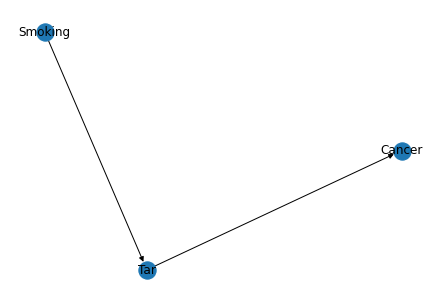

In [17]:
Ap.plot_DAG_M0()

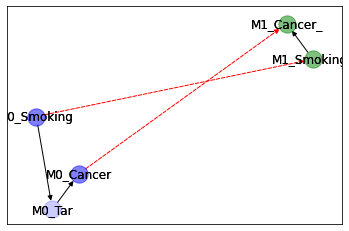

In [18]:
Ap.plot_variable_level_mapping()

## Evaluating abstraction error

Last but not least, we can instantiate a $\mathtt{ICEvaluator}$ class from *src/measuring* to compute the abstraction error. $\mathtt{ICEvaluator}$ evaluates the abstraction error based on interventional consistency as in the first notebook. $\mathtt{ICEvaluator}$ is implemented using the convention in [Zennaro2023b]. 

In [19]:
from src.measuring import ICEvaluator

As before, we instantiate it passing our abstration object.

In [20]:
Ae = ICEvaluator(A)

The $\mathtt{ICEvaluator}$ has a number of optional parameters that allows to customize the computation of the error as discussed in [Zennaro2023b].

The main function in the $\mathtt{ICEvaluator}$ is *Ae.compute_overall_error()* which computes the abstraction error using the algorithms detailed in the fourth notebook. The function has one required parameter:
- *J*: a list of pair of nodes in the abstracted model over which to compute the error or an algorithm to produce the set of nodes.

In order to compute $J$ we import the module *src/evaluationsets* which provides algorithms to compute evaluation sets, similarly to what done in the fourth notebook.

In [21]:
import src.evaluationsets as esets

In [22]:
J = esets.get_causal_sets_in_M1_with_directed_path_in_M1_and_M0(M0,M1,a)
J

[[['Smoking_'], ['Cancer_']]]

We can then compute the overall abstraction error:

In [23]:
Ae.compute_overall_error(J)

0

It is also possible to get a more detailed outcome using the *verbose* option:

In [24]:
Ae.compute_overall_error(J,verbose=True)


M1: ['Smoking_'] -> ['Cancer_']
M0: ['Smoking'] -> ['Cancer']
Args: CausalBayesianNetwork with 2 nodes and 1 edges
M1 mechanism shape: (2, 2)
M1 mechanism: [[0.9  0.66]
 [0.1  0.34]]
M0 mechanism shape: (2, 2)
Alpha_s shape: (2, 2)
Alpha_t shape: (2, 2)

Distances: [0, 0]

Error: 0

Error of pair [['Smoking_'], ['Cancer_']]: 0

Overall error: 0


0

Alternatively, the individual abstraction error for a specific pair/diagram (remember we have a diagram for each element in *J*) can be explicitly requested through the function *Ae.compute_error()*:

In [25]:
Ae.compute_error([['Smoking_'], ['Cancer_']])

0

Notice that in this case we have a single diagram, and so we get back a list with a single element. Notice, also, that *Ae.evaluate_overall_abstraction_error()* simply gets the maximum out of *Ae.evaluate_abstraction_errors()*.

## Conclusion

We have seen a basic workflow for abstraction using the code available in *src/SCMMappings.py*. Additional functions are available and explained throughout the notebooks.

## Bibliography

[Rischel2020] Rischel, Eigil Fjeldgren. "The Category Theory of Causal Models." (2020).

[Zennaro2023b] Zennaro, Fabio Massimo, Paolo Turrini, and Theodoros Damoulas. "Quantifying Consistency and Information Loss for Causal Abstraction Learning." arXiv preprint arXiv:2305.04357 (2023).